# Implementing Binary Dasymetric Interpolation
## Following an NHGIS-like Methodology 

In [1]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
import contextily as ctx
import numpy as np
import matplotlib.pyplot as plt

from tobler.area_weighted import area_interpolate
from tobler.dasymetric import extract_raster_features
from tobler.util import h3fy

%load_ext watermark
%watermark -a 'eli knaap' -v -d -u -p tobler,geopandas,rasterio

Author: eli knaap

Last updated: 2021-01-25

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.19.0

tobler   : 0.6.0
geopandas: 0.8.1
rasterio : 1.1.5



[NHGIS uses](https://www.nhgis.org/documentation/time-series/2000-blocks-to-2010-geog#advanced-model) a two step process, in which they first apply a binary dasymetric filter, then apply target density weighting. Here we will follow a similar strategy, relplicating their BD filtering (albeit with slightly different open data and replicable, open source tooling) before carrying out a simpler areal interpolation. 

>In NHGIS's BD model for 2000 block data, the inhabited zone consists of all areas that are at least 5% developed impervious surface (within each 30-meter square cell of NLCD 2001 data) and lie within 300 feet of a residential road center line2 but not in a water body, using road definitions and water polygons from the 2010 TIGER/Line Shapefiles.

so we'll start by grabbing residential streets from OSM, buffering them out 300 feet, then using that geometry to select the impervious surfaces within

In [2]:
rside_streets =  ox.geometries_from_place('Riverside County, California',tags={'highway':'residential'})

In [3]:
rside_streets = rside_streets.to_crs(2230)

/Users/knaaptime/anaconda3/envs/tobler/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
rside_streets = rside_streets.buffer(300)

In [5]:
rside_streets = gpd.GeoDataFrame(geometry=rside_streets)

In [6]:
rside_streets.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 49402 entries, 0 to 49401
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  49402 non-null  geometry
dtypes: geometry(1)
memory usage: 771.9 KB


Now we use the street buffers to extract any cells between 5 and 100% impervious surface

In [7]:
urban_rside = extract_raster_features(rside_streets, "/Users/knaaptime/Downloads/NLCD_Impervious_L48_20190405_full_zip/nlcd_impervious_2016.tif", pixel_values=list(range(5,101)), collapse_values=True)

In [8]:
urban_rside.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 24280 entries, 0 to 24279
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  24280 non-null  geometry
dtypes: geometry(1)
memory usage: 189.8 KB


/Users/knaaptime/anaconda3/envs/tobler/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
urban_rside = urban_rside.to_crs(2230)

<AxesSubplot:>

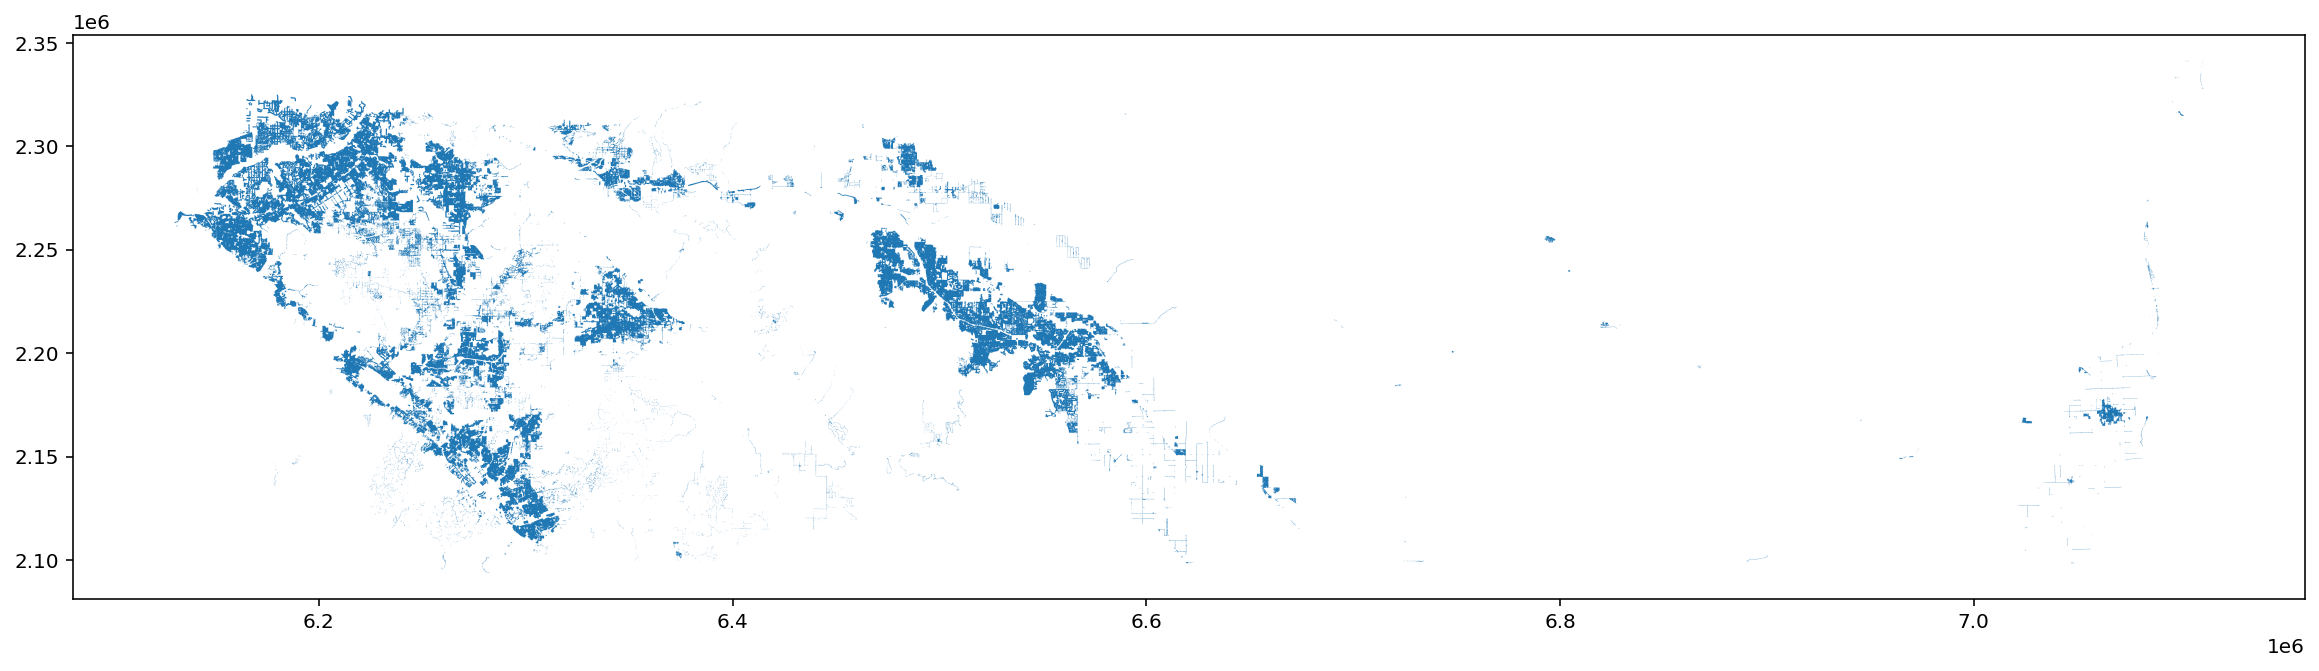

In [10]:
fig, ax = plt.subplots(figsize=(20,14))
urban_rside.plot(ax=ax)

This geodataframe represents the areas that meet both criteria NHGIS suggests

Now we need some census data to transfer geometries. Lets grab tract-level population counts using cenpy

In [11]:
from cenpy import products

/Users/knaaptime/anaconda3/envs/tobler/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
acs = products.ACS(2017)

/Users/knaaptime/anaconda3/envs/tobler/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
rside_census = acs.from_county('Riverside County', variables=['B25077_001E'])

/Users/knaaptime/anaconda3/envs/tobler/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [14]:
rside_census = rside_census.to_crs(2230)

/Users/knaaptime/anaconda3/envs/tobler/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

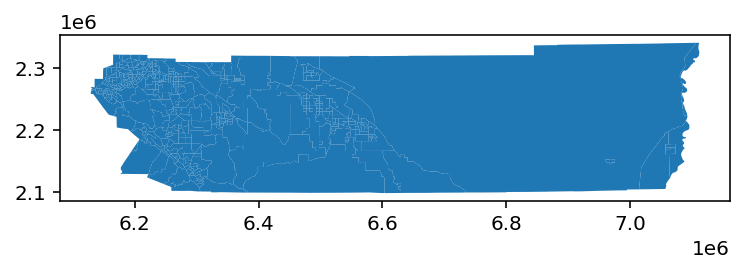

In [15]:
rside_census.plot()

And lets generate some synthetic zones to transfer this population data into using h3 hexagons

In [16]:
rside_hex = h3fy(rside_census, resolution=8)

/Users/knaaptime/anaconda3/envs/tobler/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

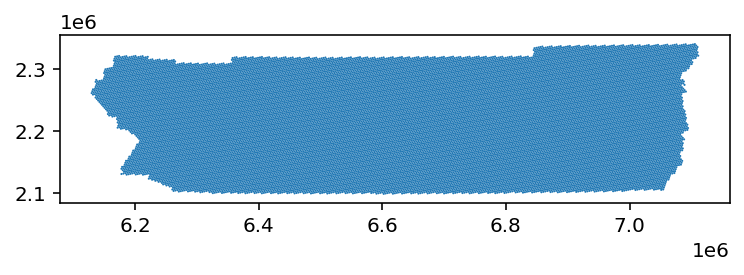

In [17]:
rside_hex.plot()

Ok, now all that's left is to clip our input census data, "restricting" it to the locations NLCD defines as 5-100% impervious. To do so, we just need to clip the census data using our extracted urban features as a mask

The commented cell below takes hours and hours because geopandas current clip function is very inefficient for these data--**dont uncomment it!**

In [18]:
#rside_dasy = gpd.clip(rside_census, urban_rside)

/Users/knaaptime/anaconda3/envs/tobler/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Instead, lets define a more efficient clip operation using the spatial index

In [19]:
def iterclip(source, mask):
    tree = mask.sindex
    features = []
    for i, row in source.iterrows():
        query = tree.query(source.geometry.iloc[i], predicate='intersects').tolist()
        submask = mask[mask.index.isin(query)]
        single = gpd.GeoDataFrame(row.to_frame(), crs=source.crs).T
        features.append(gpd.clip(single, submask))
    frame = gpd.GeoDataFrame(pd.concat(features), crs=source.crs)
    return frame

In [20]:
dasy = iterclip(rside_census, urban_rside)

<ipython-input-19-237bb4972dbd>:7: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  single = gpd.GeoDataFrame(row.to_frame(), crs=source.crs).T


Clipping census geometries by the urban features leaves the census attributes intact but reshapes them. If a census tract had 2000 people in it and covered 1 sqmi, but only a quarter mile of the tract was urbanized, the new geodataframe effectively shows these 2000 people occupying the quarter mile. By passing these new data to the `areal_interpolate` function, we're still assuming that population density is constant across our new geometries (a condition that may not be true in reality) but that assumption is much more plausible than when using original census geometries. 

<AxesSubplot:>

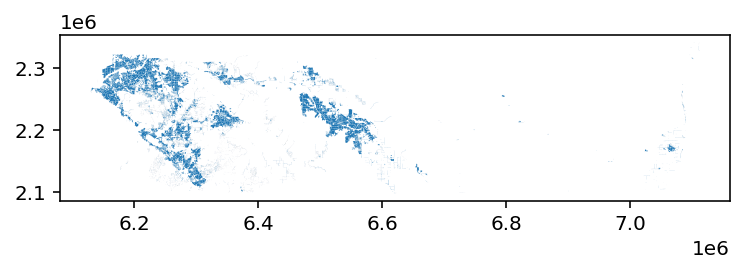

In [21]:
dasy.plot()

In [22]:
dasy.B25077_001E = dasy.B25077_001E.fillna(0)

/Users/knaaptime/anaconda3/envs/tobler/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
interp = area_interpolate(dasy, rside_hex, extensive_variables=['B25077_001E'])

In [24]:
interp['plot'] = interp.B25077_001E.apply(np.log1p)

/Users/knaaptime/anaconda3/envs/tobler/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


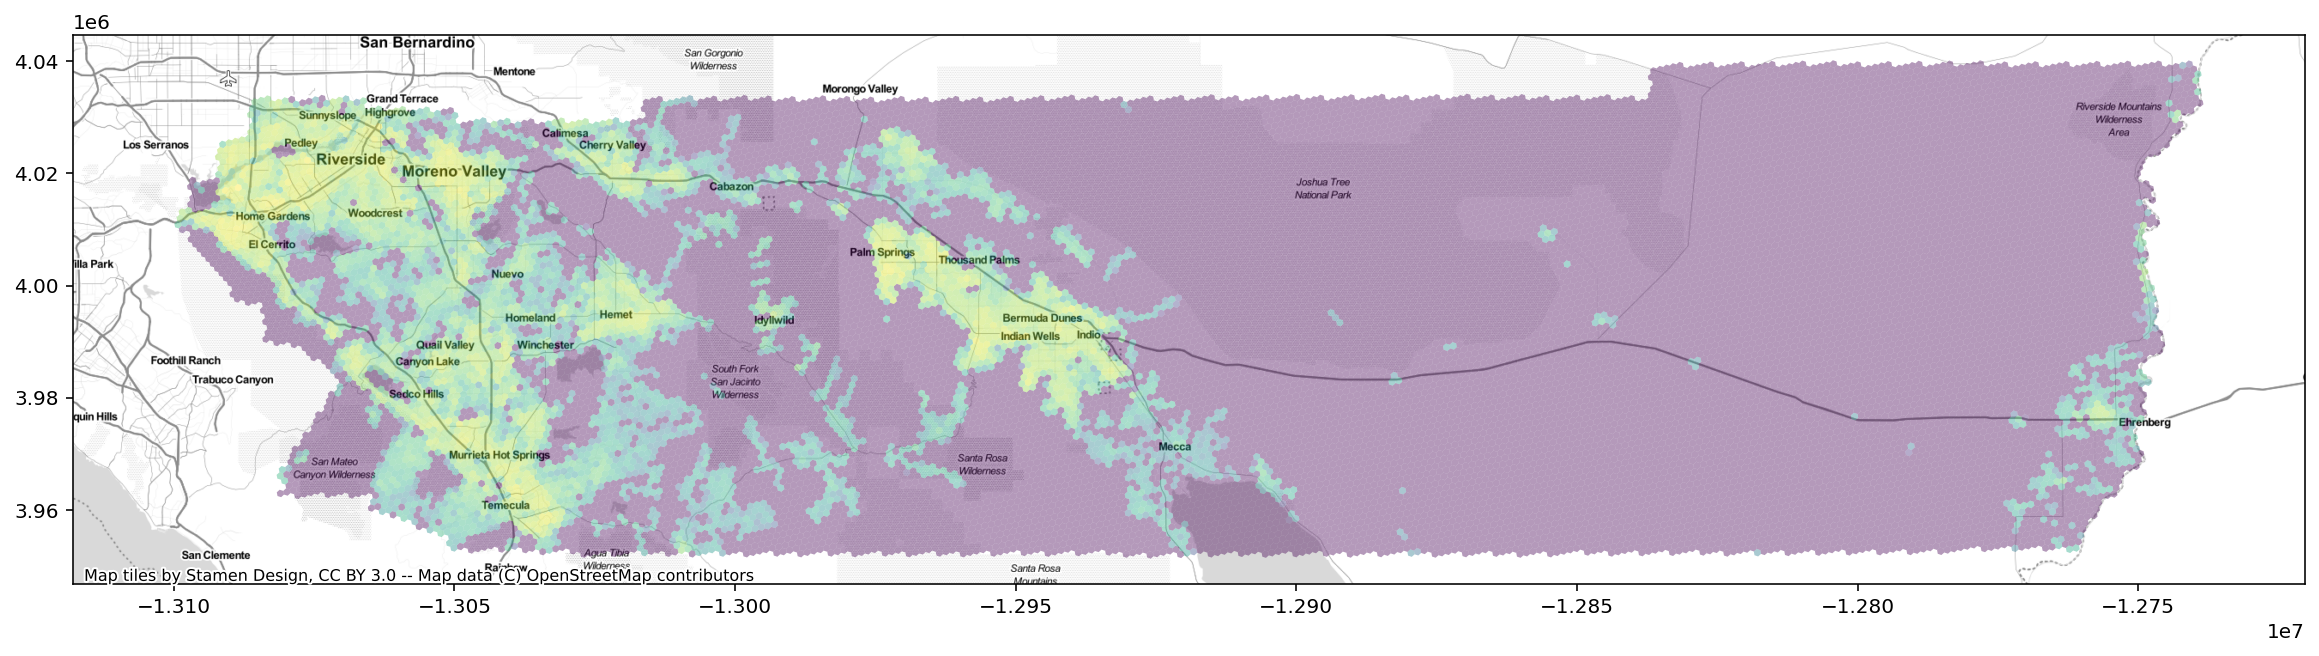

In [25]:
fig, ax = plt.subplots(figsize=(20,20))
interp.to_crs(3857).plot('plot', ax=ax,  alpha=0.4)
ctx.add_basemap(source=ctx.providers.Stamen.TonerLite, ax=ax)

And there we have it. Riverside's 2017 population estimated at a regular hexgrid